# NLP Sentiment Analysis of Yelp Data

Importing relevant libraries

In [2]:
import numpy as num
import scipy as sci
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import sklearn as skl
import xgboost
import gensim
import json
import re
import string
import seaborn as sns

In [3]:
trainingAmount = 40000
validationAmount = int(0.2 * trainingAmount)
testAmount = 10000

# Read JSON files, which are created in 'DatasetPruning' :
df_train = pd.read_json('training' + str(int(trainingAmount-validationAmount))  +'.json', lines=True)
df_validation = pd.read_json('validation' + str(validationAmount) +'.json', lines = True)
df_test = pd.read_json('test' + str(testAmount) +'.json', lines=True)

# Reorder the columns of JSON files:
df_train = df_train.drop("review_id", axis=1).drop("business_id", axis=1).drop("user_id", axis=1).drop("date", axis=1)
df_train = df_train.reindex(['text','stars','useful','funny','cool'], axis=1)

df_validation = df_validation.drop("review_id", axis=1).drop("business_id", axis=1).drop("user_id", axis=1).drop("date", axis=1)
df_validation = df_validation.reindex(['text','stars','useful','funny','cool'], axis=1)

df_test = df_test.drop("review_id", axis=1).drop("business_id", axis=1).drop("user_id", axis=1).drop("date", axis=1)
df_test = df_test.reindex(['text','stars','useful','funny','cool'], axis=1)



## Defining the clean method

In [4]:
def clean(text):
    from nltk.stem import WordNetLemmatizer
    from nltk.stem.snowball import SnowballStemmer
    from nltk.tokenize import word_tokenize
    
     # Empty question
    if type(text) != str:
        return ''
    
    text = text.lower()
    
    # remove comma between numbers, i.e. 15,000 -> 15000
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    
    text = re.sub('[' + string.punctuation + ']', ' ', text)

    text = re.sub('im', "", text)

    
    #Tokenizing text for normalizing more easily
    tokenized_text = word_tokenize(text)
    
    
    
    #Removing stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    kept_words = ['he', 'she', 'they', 'we']
    for kw in kept_words:
        stopwords.remove(kw)
    
    tokenized_text = [w for w in tokenized_text if not w in stopwords] 
    
    
    #Removing numbers
    tokenized_text = [w for w in tokenized_text if w.isalpha()]
    
    
    
    #Putting tokens back together as a string
    text = ''
    for token in tokenized_text:
        text += token + ' '
        
    
    # Return a list of words
    return text

In [5]:
df_test['length'] = df_test['text'].apply(len)
df_validation['length'] = df_validation['text'].apply(len)
df_train['length'] = df_train['text'].apply(len)


In [6]:
df_train.describe()


,stars,useful,funny,cool,length
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,3.717875,1.310375,0.472625,0.552625,591.845375
std,1.459382,2.888916,1.694804,1.990534,561.353934
min,1.000000,0.000000,0.000000,0.000000,1.000000
25%,3.000000,0.000000,0.000000,0.000000,234.000000
50%,4.000000,0.000000,0.000000,0.000000,422.000000
75%,5.000000,1.000000,0.000000,0.000000,748.000000
max,5.000000,56.000000,35.000000,52.000000,5000.000000


Cleaning the data

In [7]:
df_train['cleaned_text'] = df_train['text'].apply(clean)
df_validation['cleaned_text'] = df_validation[ 'text'].apply(clean)
df_test['cleaned_text'] = df_test['text'].apply(clean)


Saving all the necessary data in arrays

In [8]:
df_validation

,text,stars,useful,funny,cool,length,cleaned_text
0,These cakes are hands down the best cakes I ha...,5,0,0,0,163,cakes hands best cakes ever moist good coming ...
1,Why go to the movies when you can watch almost...,5,7,3,4,1060,go movies watch almost anything comfort home m...
2,Being the daughter of a mechanic I was skeptic...,4,0,0,0,776,daughter mechanic skeptical let anyone else wo...
3,Leena's has ruined falafel sandwiches for me. ...,5,1,0,0,425,leena ruined falafel sandwiches eat anywhere e...
4,This old navy just never have enough sale item...,2,0,0,0,57,old navy never enough sale items stock
5,Indus used to be right around the corner from ...,5,3,0,0,1253,indus used right around corner used beads rewa...
6,Jambalaya... That's all i have to say! It was ...,5,1,1,1,978,jambalaya say delicious mean best long te get ...
7,Came here on a weekday. We were greeted with a...,4,0,0,0,182,came weekday we greeted smile seated right awa...
8,Agree with previous posters. Order the same th...,2,0,0,0,573,agree previous posters order thing taste diffe...
9,"Solid bar, dancing is average and kinda divery...",3,1,0,0,153,solid bar dancing average kinda divery upstair...


In [9]:
train = df_train['cleaned_text'].values
validation = df_validation['cleaned_text'].values
test = df_test['cleaned_text'].values

trainStars = df_train['stars'].values
validationStars = df_validation['stars'].values
testStars = df_test['stars'].values

## BOW model with Naïve Bayes Classifier

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

vectorizer = CountVectorizer()
trainVecs = vectorizer.fit_transform(train)
testVecs = vectorizer.transform(test)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
classifierNB = MultinomialNB()
classifierNB.fit(trainVecs, trainStars)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
testStars_predicted = classifierNB.predict(testVecs)
print(classifierNB.score(testVecs, testStars)*100, "%")

60.760000000000005 %


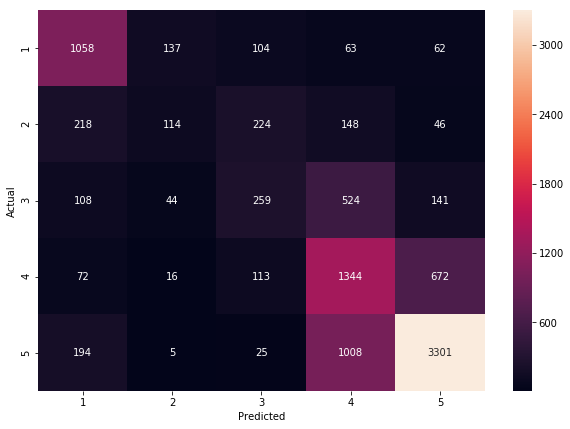

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(testStars, testStars_predicted, labels=None, sample_weight=None)

df_cm = pd.DataFrame(confusion_matrix, index = [i for i in "12345"],
                  columns = [i for i in "12345"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


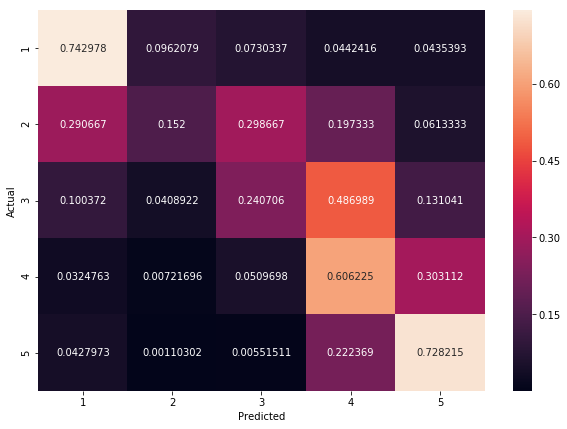

In [ ]:
confusion_matrix_proportions = []
for n in range(confusion_matrix.shape[0]):
    confusion_matrix_proportions.append(confusion_matrix[n,:]/df_test.groupby('stars').count().at[n+1, 'text'])
    
confusion_matrix_proportions = num.array(confusion_matrix_proportions)

df_cm = pd.DataFrame(confusion_matrix_proportions, index = [i for i in "12345"],
                  columns = [i for i in "12345"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
import collections
distance = num.abs(testStars - testStars_predicted)
collections.Counter(distance)

Counter({1: 2940, 0: 6076, 2: 542, 4: 256, 3: 186})

## Word2Vec model
Tokenizing the words

In [11]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

train_tokenized = [word_tokenize(token) for token in train]
validation_tokenized = [word_tokenize(token) for token in validation]
test_tokenized = [word_tokenize(token) for token in test]
word2vec = Word2Vec(train_tokenized + validation_tokenized, min_count=10) # Vector size left at default value of 100 after experimenting

word2vec.init_sims(replace=True)



In [12]:
def sent2vec(reviewTok):
    vecSize = len(word2vec.wv[reviewTok[0][0]])
    reviewVec = []
    for sentence in reviewTok:
        vectorSum = num.zeros(vecSize)
        empty = True
        for token in sentence:
            if token in word2vec.wv.vocab:
                vectorSum += word2vec.wv[token]
                empty = False
        if not empty:
            vectorSum = vectorSum / num.sqrt((vectorSum ** 2).sum())
        reviewVec.append(vectorSum)
    return num.array(reviewVec)

In [13]:
train_vectors = sent2vec(train_tokenized)
validation_vectors = sent2vec(validation_tokenized)
test_vectors = sent2vec(test_tokenized)


### XGBoost classifier

In [1]:
from xgboost import XGBClassifier

best_accuracy = 0
best_regularization = 0

regularizations = num.linspace(1e-10 , 1 ,  15)
accuracies = [ ]

for regularization in regularizations:
    
    xgbclassifier = XGBClassifier(booster = 'dart', gamma = regularization, eta = 0.03, num_round = 2,  max_depth = 5, tree_method = 'hist' )
    xgbclassifier.fit(train_vectors, trainStars)
    accuracy = xgbclassifier.score(validation_vectors, validationStars)    
    accuracies.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_regularization = regularization

    print('best accuracy:' , best_accuracy )
    print('best regularization parameter (C):' , best_regularization)
    
    best_xgbclassifier = XGBClassifier(booster = 'dart', gamma = best_regularization, eta = 0.03, num_round = 2,  max_depth = 5, tree_method = 'hist' )
    best_xgbclassifier.fit(num.vstack((train_vectors, validation_vectors)), num.vstack((trainStars, validationStars))) 
    
print(best_xgbclassifier.score(test_vectors, testStars)*100, '%')


NameError: name 'num' is not defined

### Support Vector  Machine classifier

In [ ]:
from sklearn.svm import SVC

best_accuracy = 0
best_regularization = 0

regularizations = num.linspace(1e-10 , 1 ,  15)
accuracies = [ ]

for regularization in regularizations:
    
    svc = SVC(gamma= 'auto', C= regularization)
    svc.fit(train_vectors, trainStars)
    accuracy = svc.score(validation_vectors, validationStars)    
    accuracies.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_regularization = regularization
    
  
    print('best accuracy:' , best_accuracy )
    print('best regularization parameter (C):' , best_regularization)
    
    best_svc = SVC( gamma= 'auto', C = best_regularization)
    best_svc.fit(num.vstack((train_vectors, validation_vectors)), num.vstack((trainStars, validationStars))) 
    
    print(best_svc.score(test_vectors, testStars)*100, '%')

***

### Looking for relation between text length and rating
Tests with charts

In [ ]:
g = sns.FacetGrid(data=df_test, col='stars')
g.map(plt.hist, 'length', bins=50)

In [ ]:
sns.boxplot(x='stars', y='length', data=df_test)

In [ ]:
df_test.describe()

In [ ]:
starProp_train = df_train.groupby('stars').count().drop('useful', axis=1).drop('funny', axis=1).drop('cool', axis=1).drop('length', axis=1)
starProp_train['percentage'] = starProp_train['cleaned_text'] / df_train.shape[0] * 100
starProp_train


In [ ]:
starProp_test = df_test.groupby('stars').count().drop('useful', axis=1).drop('funny', axis=1).drop('cool', axis=1).drop('length', axis=1)
starProp_test['percentage'] = starProp_test['cleaned_text'] / df_test.shape[0] * 100
starProp_test


Training and test set have same proportions! :-)

ideas:
- make a numbers token <NUMBER>
- stem the words
- remove stopwords
- create a personal noun token <PERSONALNOUN>

In [ ]:
validation_vectors